In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
import random,copy,math
import numpy as np
import matplotlib.pyplot as plt
import time
pi = round(math.pi,6)
sin,cos,tan = math.sin,math.cos,math.tan

delta_t = 0.2
car_vel = 10
car_omega = 0
target_pos = np.array([10,10,0])

MAX_POPULATION_SIZE=20  #maximum number of plants in a colony(or population)
sigma_fin=0.01  #final standard deviation
sigma_ini=35  #initial standard deviation
Smin=2        #min seeds produced
Smax=10       #max seeds produced
n_mi= 3       #modulation index
iter_max=1500 #Maximum number of iterations to be done
CHROMOSOME_SIZE=6 #v_x,v_y,v_Z,omega_x,omega_y,omega_z

#Input Limits
v_x_min,v_x_max = -15,15
v_y_min,v_y_max = -15,15
v_z_min,v_z_max = -11,11
omega_x_min,omega_x_max = -(pi/5),pi/5
omega_y_min,omega_y_max = -(pi/5),pi/5
omega_z_min,omega_z_max = -(pi/5),pi/5

#class that generates chromosomes
class Chromosome:
    def __init__(self,state,tar_curr_state,mode =" "):
        self._genes=np.zeros((CHROMOSOME_SIZE+1),dtype=float)
        self._state = state #current state of the chaser
        self._tar_curr_state = tar_curr_state #current state of the target
        self.new_tar_state = 0

        #initializing the control parameters
        if mode=="initialise":  
            
            self._genes[0] = v_x_min+(v_x_max-v_x_min) * random.random()
            self._genes[1] = v_y_min+(v_y_max-v_y_min) * random.random()
            self._genes[2] = v_z_min+(v_z_max-v_z_min) * random.random()
            self._genes[3] = omega_x_min+(omega_x_max - omega_x_min)*random.random()
            self._genes[4] = omega_y_min+(omega_y_max - omega_y_min)*random.random()
            self._genes[5] = omega_z_min+(omega_z_max - omega_z_min)*random.random()

        self._cost = self.get_cost() #calculating cost
        self._genes[-1] = self._cost #adding cost to the genes

        
    def get_genes(self):
        return self._genes

    def get_cost(self):
        
        vel = self._genes[:3]
        omega = self._genes[3:-1]

        pos = self._state[0]
        angle = self._state[1]
        phi,theta,psi = angle

               
        rotmat_velocity = np.array([[cos(theta),sin(phi)*sin(theta),cos(phi)*sin(theta)],\
                                    [0,cos(phi),-sin(phi)],\
                                    [-sin(theta),sin(phi)*cos(theta),cos(phi)*cos(theta)]])
        
        pos = pos + np.matmul(rotmat_velocity,vel)*delta_t
        angle = angle + omega*delta_t
     

        curr_pos = np.array([pos,angle])

        #getting target position
        self.new_target_state = self.cal_target_state() #updating new target state
        self._state = curr_pos #updating new chaser state
        cost = np.sum((self.new_target_state[:2]-curr_pos[0][:2])**2) #+ abs(curr_pos[0][2]-50))/51 #- curr_pos[0][2]*1000 #calculating cost

        return cost

    def get_state(self):
        return self._state

    def cal_target_state(self):
        theta = self._tar_curr_state[-1] + (car_omega*delta_t)
        x = self._tar_curr_state[0] + car_vel * math.cos(theta) * delta_t
        y = self._tar_curr_state[1] + car_vel * math.sin(theta) * delta_t
        return np.array([x,y,0,theta])

    def get_target_state(self):
      return self.new_target_state
    
    def __str__(self):
        return self._genes.__str__()

#class that create one set of generations
class Population:
    def __init__(self,size,curr_state,tar_curr_state,mode=" "):
        self._chromosomes=[]
        i=0
        while i<size:
            self.add_chromosomes(Chromosome(curr_state,tar_curr_state,mode))
            i+=1
    def add_chromosomes(self,chromosome):
        self._chromosomes.append(chromosome)
    def get_chromosomes(self):
        return self._chromosomes

#class that helps in evolving and mutating the genes of the chromosomes
class GeneticAlgorithm:

    @staticmethod
    def reproduce(pop,iter,curr_state,tar_curr_state):
        new_pop=copy.deepcopy(pop)
        worst_cost=pop.get_chromosomes()[MAX_POPULATION_SIZE-1].get_genes()[CHROMOSOME_SIZE]
        best_cost=pop.get_chromosomes()[0].get_genes()[CHROMOSOME_SIZE]
        sigma_iter=GeneticAlgorithm.std_deviation(iter,iter_max)
        if(best_cost!=worst_cost):
            
            for i in range(MAX_POPULATION_SIZE):
                ratio=(pop.get_chromosomes()[i].get_genes()[CHROMOSOME_SIZE]-worst_cost)/(best_cost-worst_cost)
                S=Smin+(Smax-Smin)*ratio #number of seeds chromosome can produce on the basis of rank
                for j in range(int(S)):
                    seed=Chromosome(curr_state,tar_curr_state)
                    for k in range(CHROMOSOME_SIZE):
                        seed._genes[k]=np.random.normal(pop._chromosomes[i].get_genes()[k],sigma_iter)
                   
                    new_pop.add_chromosomes(seed)
            GeneticAlgorithm.sort(new_pop)
            pop._chromosomes=new_pop._chromosomes[:MAX_POPULATION_SIZE]
            
        else:
            # print("best and worst cost equal")
            return pop, False
        # print("REPRODUCED")
        return pop, True
    @staticmethod
    def std_deviation(iter,iter_max):
        sigma_iter=(((iter_max-iter)**n_mi)/iter_max**n_mi)*(sigma_ini-sigma_fin)+sigma_fin
        # print ("sigma",sigma_iter,'\n')
        return sigma_iter
    @staticmethod
    def sort(pop):
        pop_chroms_2d_array=np.array([pop.get_chromosomes()[i].get_genes() for i in range(len(pop._chromosomes))])
        sindices=np.argsort(pop_chroms_2d_array[:,CHROMOSOME_SIZE],axis=0)
        
        sorted_chroms=pop.get_chromosomes()
        for i in range(0,len(pop._chromosomes)):
            sorted_chroms[i]._genes=pop_chroms_2d_array[sindices[i]]
            sorted_chroms[i]._state = pop._chromosomes[sindices[i]]._state
        
        pop._chromosomes=sorted_chroms
        # print("SORTED")
#------------------------------------------------------------------------------------------------------------------------------------#-
def _print_population(pop,gen_number,fitness):
    print("\n---------------------------------------------------------")
    print("Generation#",gen_number,"|Fittest chromosome fitness:",pop.get_chromosomes()[0].get_genes()[CHROMOSOME_SIZE])
    #print("Target Chromosome:",TARGET_CHROMOSOME)
    print("-----------------------------------------------------------")
    fitness.append(pop.get_chromosomes()[0].get_genes()[CHROMOSOME_SIZE])
    i=0
    for x in pop.get_chromosomes():
        print("Chromosome #",i+1,":",x.get_genes(),"|State: ",x.get_state(),"|Fitness:",x.get_genes()[CHROMOSOME_SIZE])
        k=x.get_genes()[CHROMOSOME_SIZE]
        i+=1


def optimizer(curr_state,tar_curr_state):
  # print("INITIATING PROGRAMME")
  population=Population(MAX_POPULATION_SIZE,curr_state,tar_curr_state,"initialise")#initialising population
  GeneticAlgorithm.sort(population)
  fitness = []
  iter=1
  
  while iter<iter_max:

      population,check=GeneticAlgorithm.reproduce(population,iter,curr_state,tar_curr_state)

      if(check==False):
          #iter+=1
          break;
      
      iter+=1
  
  new_chaser_state,new_target_state = population.get_chromosomes()[0].get_state(),population.get_chromosomes()[0].get_target_state()
  return(new_chaser_state,new_target_state)




step:  0 chaser state:  [[ 2.62312504e+00  4.04616293e+00  4.84052669e+01]
 [-3.63109435e-02  8.35114798e-02 -1.33960292e-01]] target state:  [ 9.99999931 14.          0.          1.5707965 ]


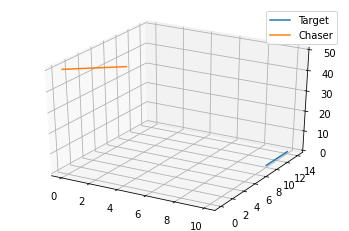


step:  1 chaser state:  [[ 5.16809564e+00  5.48636589e+00  4.88403993e+01]
 [-7.76432422e-03  1.40155655e-02 -1.17101213e-01]] target state:  [ 9.99999896 16.          0.          1.5707965 ]


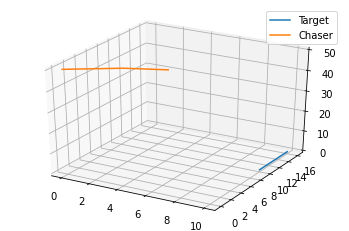


step:  2 chaser state:  [[ 4.36039794e+00  8.44156596e+00  4.77726717e+01]
 [-4.36801855e-02 -9.32709450e-02 -1.40829242e-01]] target state:  [ 9.99999861 18.          0.          1.5707965 ]


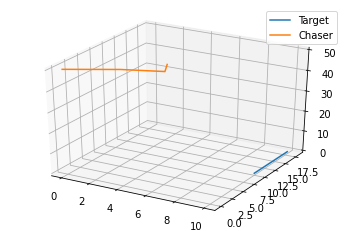


step:  3 chaser state:  [[ 7.38179919 11.3162382  46.19166463]
 [-0.09501652 -0.19118983 -0.1566361 ]] target state:  [ 9.99999827 20.          0.          1.5707965 ]


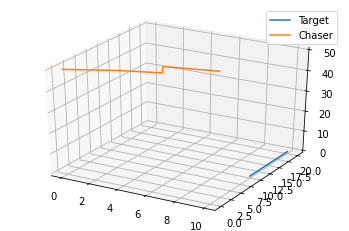


step:  4 chaser state:  [[ 8.21305378e+00  1.32774852e+01  4.72748721e+01]
 [-3.04281250e-02 -2.80787061e-01 -6.90155134e-02]] target state:  [ 9.99999792 22.          0.          1.5707965 ]


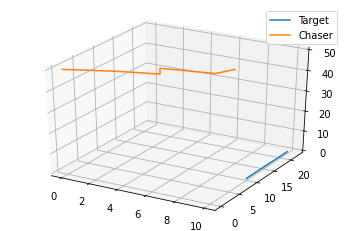


step:  5 chaser state:  [[11.23552791 15.90781957 47.24793375]
 [ 0.09109616 -0.2184558  -0.0914262 ]] target state:  [ 9.99999758 24.          0.          1.5707965 ]


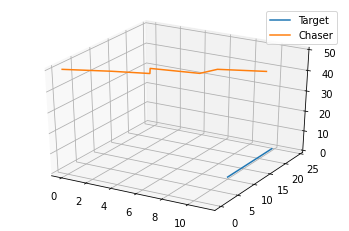


step:  6 chaser state:  [[ 1.02147853e+01  1.86898573e+01  4.87555551e+01]
 [ 3.14577114e-02 -1.71280592e-01 -3.69634090e-02]] target state:  [ 9.99999723 26.          0.          1.5707965 ]


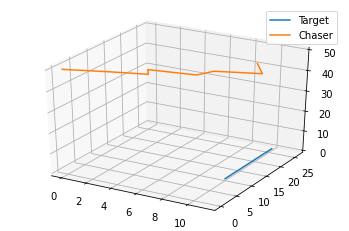


step:  7 chaser state:  [[12.27997144 21.56677999 47.69517636]
 [ 0.11997767 -0.26487041 -0.08907342]] target state:  [ 9.99999688 28.          0.          1.5707965 ]


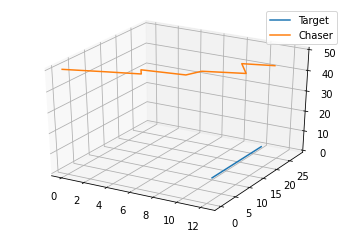


step:  8 chaser state:  [[10.38258986 24.48936239 46.86279295]
 [ 0.22466854 -0.3218499  -0.13318451]] target state:  [ 9.99999654 30.          0.          1.5707965 ]


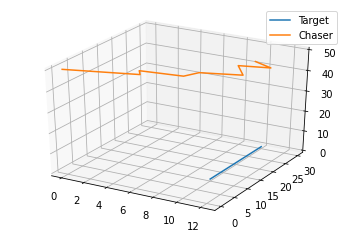


step:  9 chaser state:  [[12.79302116 26.41934519 46.92656045]
 [ 0.3225803  -0.36335813 -0.12967265]] target state:  [ 9.99999619 32.          0.          1.5707965 ]


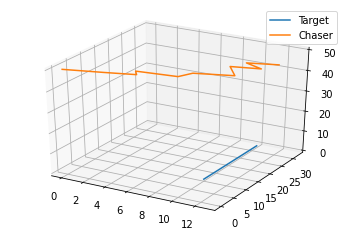


step:  10 chaser state:  [[ 1.02400976e+01  2.93520107e+01  4.65175844e+01]
 [ 3.77165569e-01 -3.65807392e-01 -2.37705204e-02]] target state:  [ 9.99999584 34.          0.          1.5707965 ]


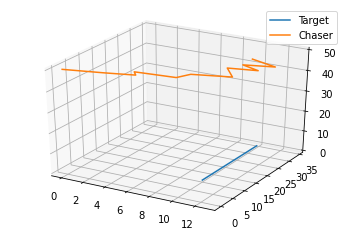


step:  11 chaser state:  [[ 9.06220087 32.0789254  45.05829467]
 [ 0.4787217  -0.25162925 -0.1467965 ]] target state:  [ 9.9999955 36.         0.         1.5707965]


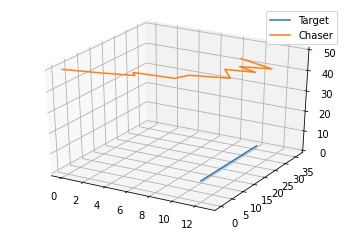


step:  12 chaser state:  [[11.8107205  34.02631352 44.33122901]
 [ 0.49435576 -0.19038327 -0.20711297]] target state:  [ 9.99999515 38.          0.          1.5707965 ]


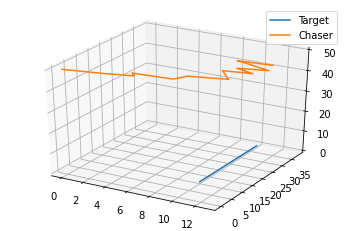


step:  13 chaser state:  [[10.42813638 36.75881585 43.05706206]
 [ 0.5997122  -0.07569252 -0.2837203 ]] target state:  [ 9.9999948 40.         0.         1.5707965]


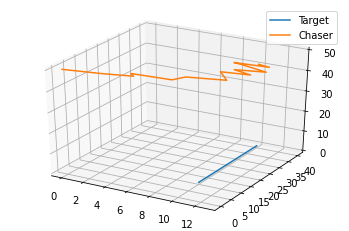


step:  14 chaser state:  [[10.36366086 39.35504435 42.91676622]
 [ 0.6331407  -0.10306433 -0.39894644]] target state:  [ 9.99999446 42.          0.          1.5707965 ]


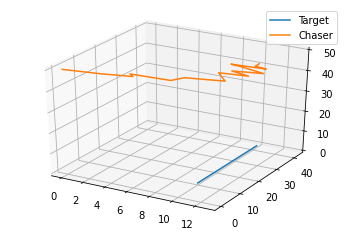


step:  15 chaser state:  [[ 8.95807136 42.96016221 42.81485857]
 [ 0.68819938 -0.13859368 -0.30742325]] target state:  [ 9.99999411 44.          0.          1.5707965 ]


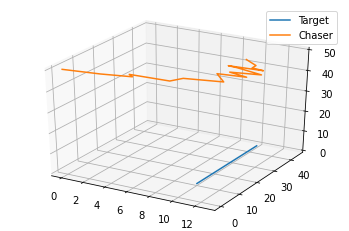


step:  16 chaser state:  [[11.08357262 43.84759501 42.86060375]
 [ 0.56570961 -0.11266268 -0.31753835]] target state:  [ 9.99999376 46.          0.          1.5707965 ]


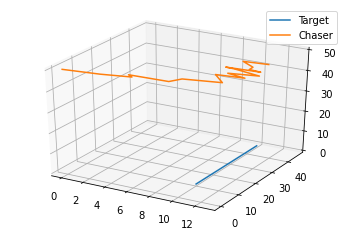


step:  17 chaser state:  [[ 1.12498615e+01  4.64264263e+01  4.42885213e+01]
 [ 6.44255167e-01 -1.25787037e-02 -2.24584143e-01]] target state:  [ 9.99999342 48.          0.          1.5707965 ]


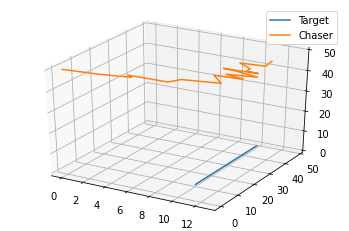


step:  18 chaser state:  [[10.45396054 49.28962408 44.35630476]
 [ 0.69587981 -0.13132078 -0.26225426]] target state:  [ 9.99999307 50.          0.          1.5707965 ]


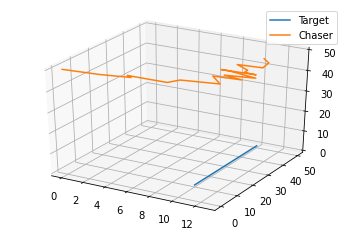


step:  19 chaser state:  [[ 9.82438933 50.96129749 45.03101968]
 [ 0.76635172 -0.11825078 -0.13684926]] target state:  [ 9.99999273 52.          0.          1.5707965 ]


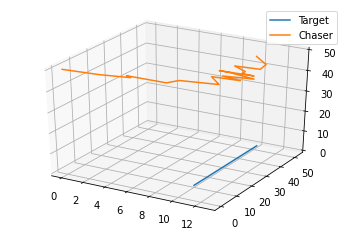


step:  20 chaser state:  [[10.34528307 51.92802084 45.59360395]
 [ 0.75566752 -0.22406701 -0.14502107]] target state:  [ 9.99999238 54.          0.          1.5707965 ]


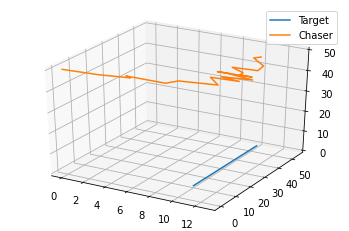


step:  21 chaser state:  [[ 9.100119   54.73972209 46.0980061 ]
 [ 0.66150807 -0.29478308 -0.18276268]] target state:  [ 9.99999203 56.          0.          1.5707965 ]


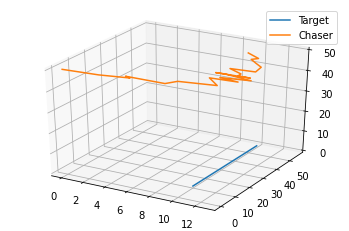


step:  22 chaser state:  [[11.01280039 56.0283201  45.62109383]
 [ 0.61522088 -0.23880184 -0.28744634]] target state:  [ 9.99999169 58.          0.          1.5707965 ]


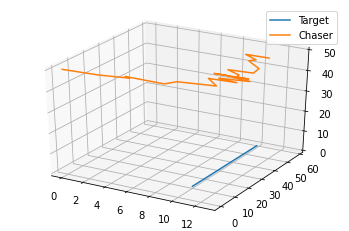


step:  23 chaser state:  [[ 9.34469695 58.8890894  44.68903462]
 [ 0.52434542 -0.22744064 -0.25728611]] target state:  [ 9.99999134 60.          0.          1.5707965 ]


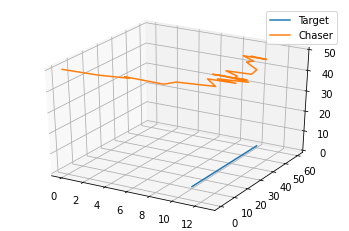


step:  24 chaser state:  [[10.02278198 61.16257836 46.71385225]
 [ 0.62875318 -0.20073576 -0.21139136]] target state:  [ 9.99999099 62.          0.          1.5707965 ]


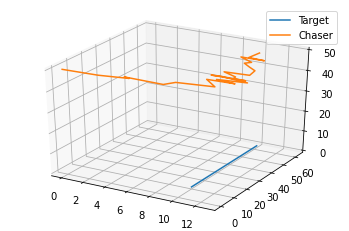


step:  25 chaser state:  [[10.33936988 62.17000117 48.87856559]
 [ 0.67858475 -0.25153412 -0.10100166]] target state:  [ 9.99999065 64.          0.          1.5707965 ]


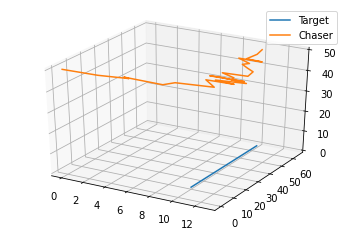


step:  26 chaser state:  [[10.57563928 64.47002422 48.47275076]
 [ 0.69361406 -0.19921094 -0.18938917]] target state:  [ 9.9999903 66.         0.         1.5707965]


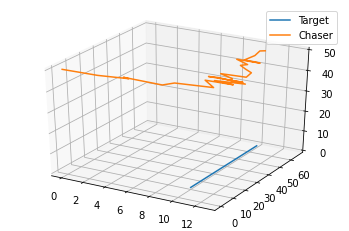


step:  27 chaser state:  [[11.51176678 66.03053683 48.44029182]
 [ 0.74998931 -0.32091821 -0.13861804]] target state:  [ 9.99998995 68.          0.          1.5707965 ]


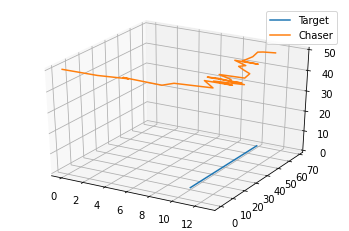


step:  28 chaser state:  [[11.63144608 68.89149033 48.37578594]
 [ 0.83008006 -0.40318178 -0.2228592 ]] target state:  [ 9.99998961 70.          0.          1.5707965 ]


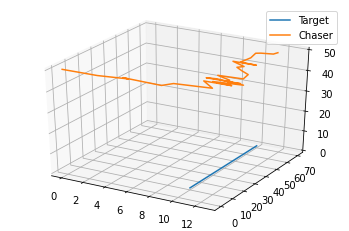


step:  29 chaser state:  [[10.56523354 70.64705564 46.94316701]
 [ 0.76120947 -0.50253895 -0.17572215]] target state:  [ 9.99998926 72.          0.          1.5707965 ]


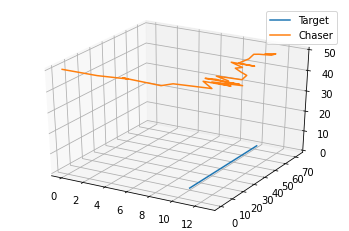


step:  30 chaser state:  [[ 9.29404662 73.26707914 46.30481491]
 [ 0.76707685 -0.40259788 -0.20854678]] target state:  [ 9.99998891 74.          0.          1.5707965 ]


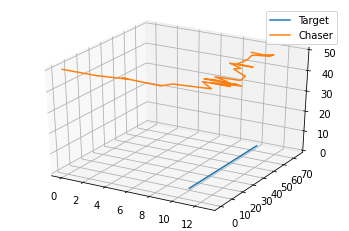


step:  31 chaser state:  [[10.00045181 74.57286534 45.65514198]
 [ 0.68890282 -0.31809523 -0.18141248]] target state:  [ 9.99998857 76.          0.          1.5707965 ]


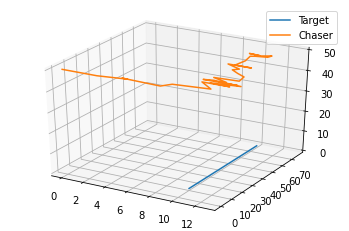


step:  32 chaser state:  [[ 8.89475824 77.11428941 46.38506415]
 [ 0.78217546 -0.34037814 -0.22175699]] target state:  [ 9.99998822 78.          0.          1.5707965 ]


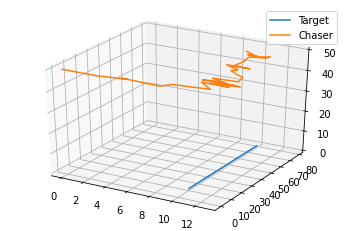


step:  33 chaser state:  [[10.02430831 79.59884614 46.5014424 ]
 [ 0.73074593 -0.39654212 -0.15041431]] target state:  [ 9.99998788 80.          0.          1.5707965 ]


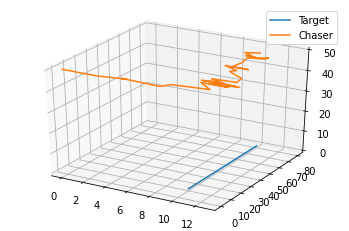


step:  34 chaser state:  [[ 9.65502306 81.75254551 47.15306923]
 [ 0.74719814 -0.3615858  -0.18396174]] target state:  [ 9.99998753 82.          0.          1.5707965 ]


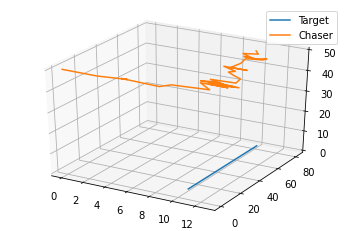


step:  35 chaser state:  [[ 9.8398951  84.19121016 47.35589836]
 [ 0.69824388 -0.47182719 -0.11970944]] target state:  [ 9.99998718 84.          0.          1.5707965 ]


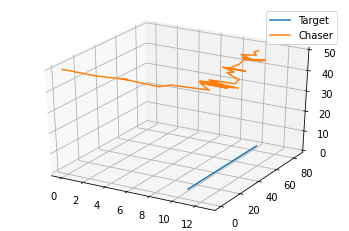


step:  36 chaser state:  [[ 9.57624444 85.3185348  48.81435899]
 [ 0.7419314  -0.38466609 -0.11039201]] target state:  [ 9.99998684 86.          0.          1.5707965 ]


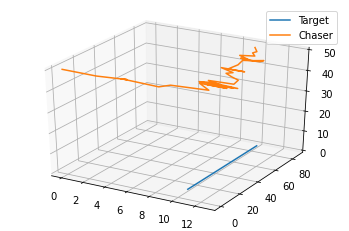


step:  37 chaser state:  [[10.9463983  87.95047867 48.97922061]
 [ 0.85489995 -0.2672241  -0.17194635]] target state:  [ 9.99998649 88.          0.          1.5707965 ]


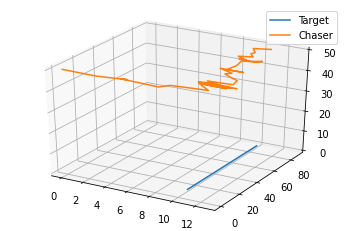


step:  38 chaser state:  [[10.26131466 90.40467918 49.3761972 ]
 [ 0.93327926 -0.31217465 -0.25367705]] target state:  [ 9.99998614 90.          0.          1.5707965 ]


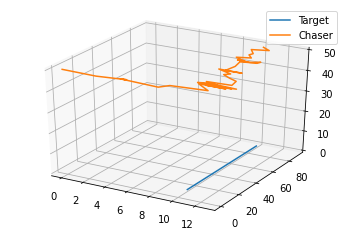


step:  39 chaser state:  [[10.64677449 91.40890311 47.91334594]
 [ 0.84579804 -0.20792125 -0.21300853]] target state:  [ 9.9999858 92.         0.         1.5707965]


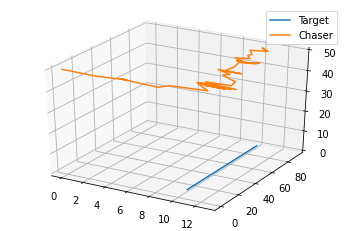


step:  40 chaser state:  [[ 9.67652105 93.93954844 48.29414292]
 [ 0.72131031 -0.15101317 -0.1404581 ]] target state:  [ 9.99998545 94.          0.          1.5707965 ]


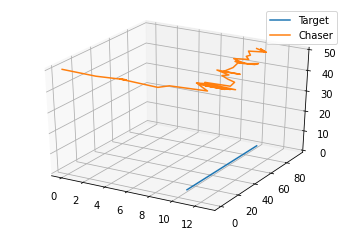


step:  41 chaser state:  [[ 9.90235716e+00  9.67207737e+01  4.86139906e+01]
 [ 6.73535473e-01 -2.37751111e-01 -7.51071720e-02]] target state:  [ 9.9999851 96.         0.         1.5707965]


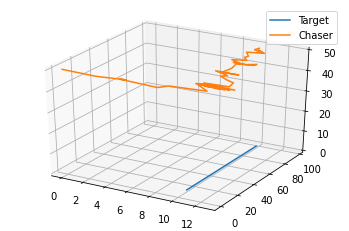


step:  42 chaser state:  [[10.60016059 97.76336504 48.33322612]
 [ 0.79427083 -0.17687126 -0.14128252]] target state:  [ 9.99998476 98.          0.          1.5707965 ]


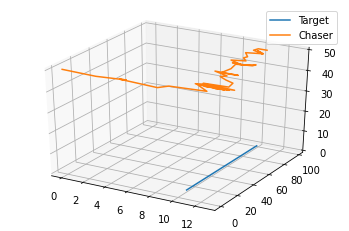


step:  43 chaser state:  [[ 10.23300882 100.48099604  49.08240301]
 [  0.78186417  -0.21808292  -0.2433833 ]] target state:  [  9.99998441 100.           0.           1.5707965 ]


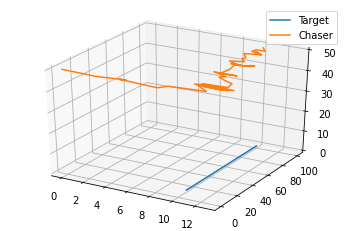


step:  44 chaser state:  [[ 10.20748899 100.98854428  49.8794001 ]
 [  0.78119573  -0.22542673  -0.14933971]] target state:  [  9.99998407 102.           0.           1.5707965 ]


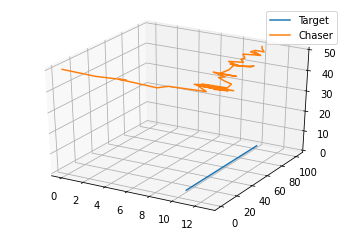


step:  45 chaser state:  [[ 9.51952638e+00  1.04315240e+02  4.99785367e+01]
 [ 7.27574867e-01 -1.57850308e-01 -7.08223514e-02]] target state:  [  9.99998372 104.           0.           1.5707965 ]


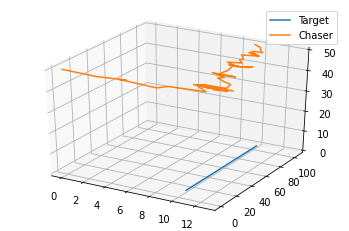


step:  46 chaser state:  [[ 10.25584654 106.40241869  51.16883713]
 [  0.63583263  -0.26636145  -0.11225319]] target state:  [  9.99998337 106.           0.           1.5707965 ]


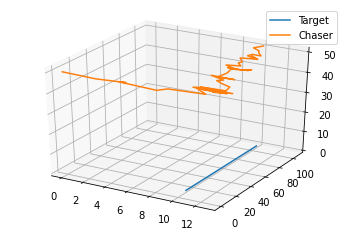


step:  47 chaser state:  [[ 9.36874312e+00  1.07363444e+02  4.99023578e+01]
 [ 6.23186178e-01 -3.22181343e-01 -6.69962977e-02]] target state:  [  9.99998303 108.           0.           1.5707965 ]


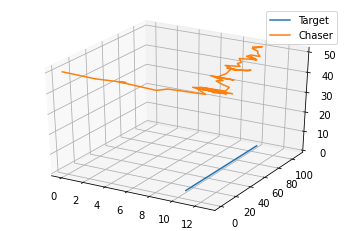


step:  48 chaser state:  [[ 9.51391638e+00  1.10045677e+02  5.03146235e+01]
 [ 6.02754419e-01 -2.76159627e-01 -1.45549604e-02]] target state:  [  9.99998268 110.           0.           1.5707965 ]


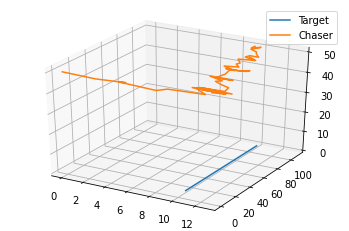


step:  49 chaser state:  [[ 11.10462257 111.52369715  50.65256318]
 [  0.55688207  -0.25425001  -0.11273828]] target state:  [  9.99998233 112.           0.           1.5707965 ]


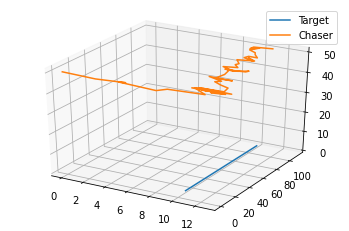


step:  50 chaser state:  [[ 1.03548987e+01  1.13166367e+02  4.94470264e+01]
 [ 4.32372164e-01 -2.77625763e-01 -8.87411131e-02]] target state:  [  9.99998199 114.           0.           1.5707965 ]


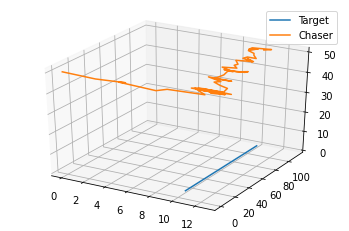


step:  51 chaser state:  [[ 9.67890501e+00  1.15392809e+02  4.92988717e+01]
 [ 3.18414056e-01 -3.15617748e-01 -1.09928529e-01]] target state:  [  9.99998164 116.           0.           1.5707965 ]


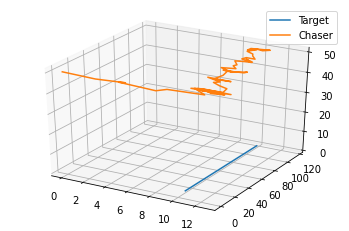


step:  52 chaser state:  [[ 10.71829649 117.08587981  50.77144091]
 [  0.43596415  -0.29606527  -0.13677467]] target state:  [  9.99998129 118.           0.           1.5707965 ]


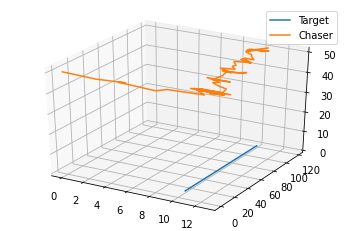


step:  53 chaser state:  [[ 1.06029409e+01  1.19475231e+02  5.21247311e+01]
 [ 3.61321434e-01 -2.82159917e-01 -7.12357861e-02]] target state:  [  9.99998095 120.           0.           1.5707965 ]


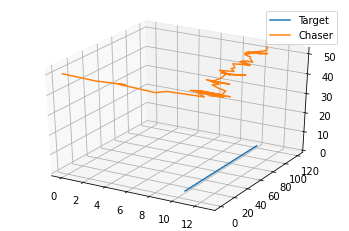


step:  54 chaser state:  [[ 10.82321308 121.22578169  53.50910021]
 [  0.43805895  -0.31927389  -0.17218994]] target state:  [  9.9999806 122.          0.          1.5707965]


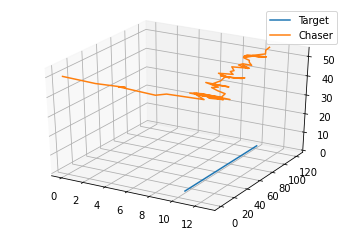


step:  55 chaser state:  [[ 10.00939019 123.92956093  52.49731791]
 [  0.51631987  -0.36455454  -0.2585341 ]] target state:  [  9.99998025 124.           0.           1.5707965 ]


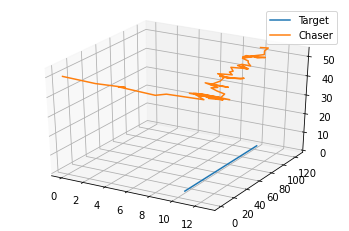


step:  56 chaser state:  [[ 10.17465085 125.93933253  53.4860111 ]
 [  0.52461963  -0.47364181  -0.26469022]] target state:  [  9.99997991 126.           0.           1.5707965 ]


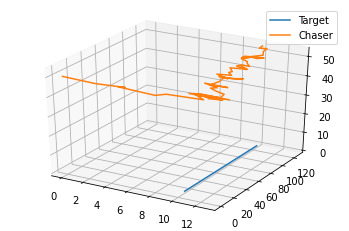


step:  57 chaser state:  [[ 10.33606035 128.16823746  52.31934748]
 [  0.45878491  -0.49581897  -0.34568261]] target state:  [  9.99997956 128.           0.           1.5707965 ]


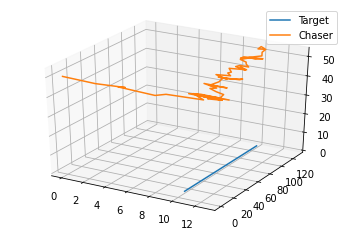


step:  58 chaser state:  [[ 10.37280325 130.0839316   55.53320158]
 [  0.34778579  -0.49286345  -0.26883967]] target state:  [  9.99997922 130.           0.           1.5707965 ]


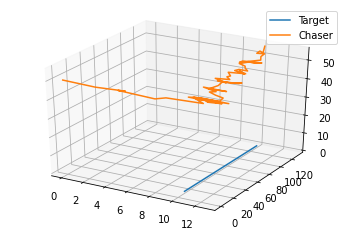


step:  59 chaser state:  [[  9.39513149 132.10807155  54.75036804]
 [  0.32370415  -0.48936814  -0.18833796]] target state:  [  9.99997887 132.           0.           1.5707965 ]


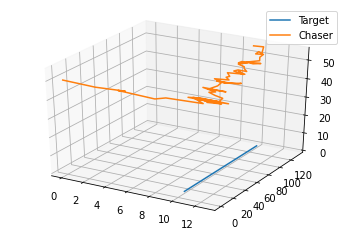


step:  60 chaser state:  [[  9.76841257 133.03405853  57.72926586]
 [  0.43659893  -0.60152602  -0.13791175]] target state:  [  9.99997852 134.           0.           1.5707965 ]


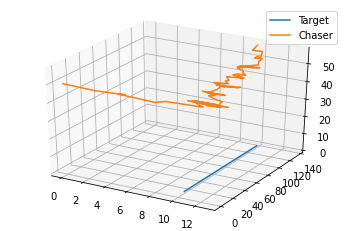


step:  61 chaser state:  [[ 9.64160688e+00  1.34383226e+02  5.59362244e+01]
 [ 5.54948781e-01 -6.54807422e-01 -5.35911026e-02]] target state:  [  9.99997818 136.           0.           1.5707965 ]


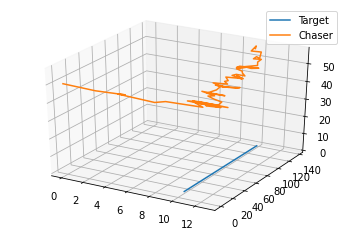


step:  62 chaser state:  [[ 1.11925473e+01  1.37063751e+02  5.65631831e+01]
 [ 6.63191442e-01 -6.36398928e-01 -7.59067429e-02]] target state:  [  9.99997783 138.           0.           1.5707965 ]


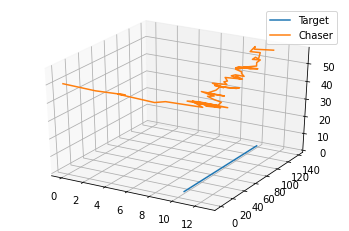


step:  63 chaser state:  [[ 1.00268941e+01  1.39999325e+02  5.52989781e+01]
 [ 7.08479350e-01 -5.74859799e-01 -2.18251760e-02]] target state:  [  9.99997748 140.           0.           1.5707965 ]


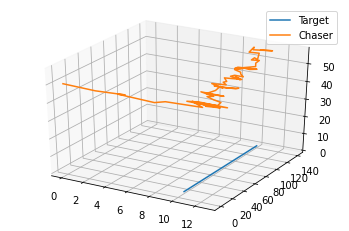


step:  64 chaser state:  [[ 9.77169075e+00  1.41643212e+02  5.52566120e+01]
 [ 6.30940949e-01 -6.93712755e-01 -1.26460019e-01]] target state:  [  9.99997714 142.           0.           1.5707965 ]


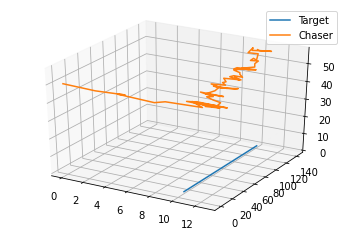


step:  65 chaser state:  [[  9.49302485 143.0649152   58.68786793]
 [  0.65366709  -0.81035155  -0.20103971]] target state:  [  9.99997679 144.           0.           1.5707965 ]


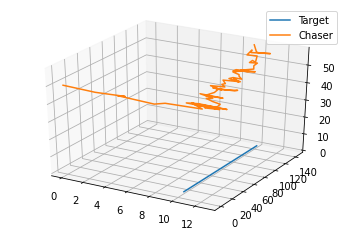


step:  66 chaser state:  [[ 11.0045194  144.59074942  60.03518793]
 [  0.77230246  -0.8787477   -0.25794188]] target state:  [  9.99997644 146.           0.           1.5707965 ]


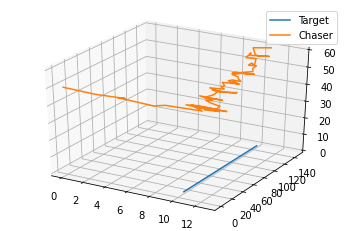


step:  67 chaser state:  [[ 11.2742457  146.78784611  59.71424515]
 [  0.82864222  -0.85762191  -0.20048318]] target state:  [  9.9999761 148.          0.          1.5707965]


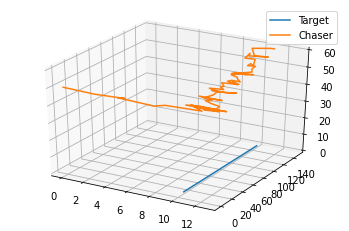


step:  68 chaser state:  [[ 10.47882917 149.62103826  60.34395415]
 [  0.80147302  -0.97781891  -0.20838161]] target state:  [  9.99997575 150.           0.           1.5707965 ]


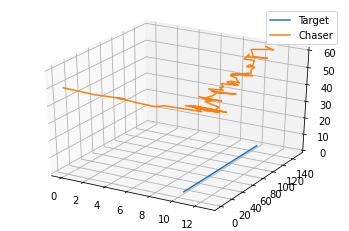


step:  69 chaser state:  [[ 1.03437861e+01  1.51932798e+02  6.08243106e+01]
 [ 8.09556785e-01 -9.39229742e-01 -1.34562346e-01]] target state:  [  9.9999754 152.          0.          1.5707965]


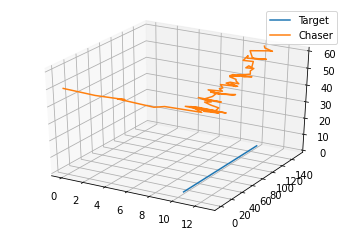


step:  70 chaser state:  [[ 10.99872791 153.93456749  62.25893838]
 [  0.70761356  -0.97139255  -0.17156294]] target state:  [  9.99997506 154.           0.           1.5707965 ]


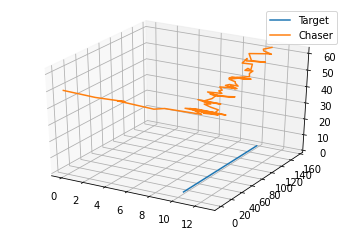


step:  71 chaser state:  [[  9.56041948 155.64120773  61.5946608 ]
 [  0.80049817  -1.07786765  -0.19052494]] target state:  [  9.99997471 156.           0.           1.5707965 ]


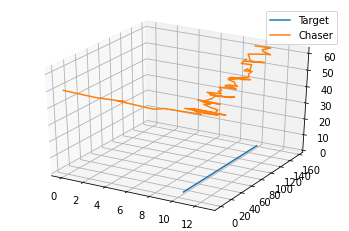


step:  72 chaser state:  [[  9.85149958 158.18616628  61.55274674]
 [  0.70445054  -0.98975775  -0.28432021]] target state:  [  9.99997437 158.           0.           1.5707965 ]


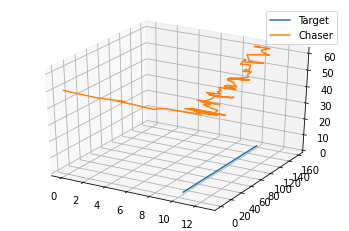


step:  73 chaser state:  [[ 10.24300786 160.4383577   61.57739728]
 [  0.63198781  -1.03749826  -0.26265319]] target state:  [  9.99997402 160.           0.           1.5707965 ]


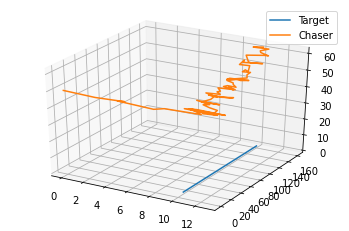


step:  74 chaser state:  [[  9.76179486 161.77023001  58.71457307]
 [  0.61943395  -1.06705552  -0.20649563]] target state:  [  9.99997367 162.           0.           1.5707965 ]


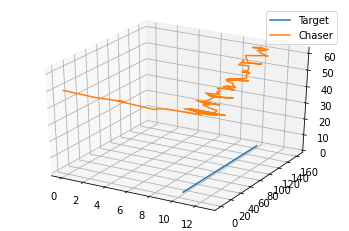


step:  75 chaser state:  [[  9.82363473 164.25999438  61.21177159]
 [  0.60157462  -1.0617344   -0.24116622]] target state:  [  9.99997333 164.           0.           1.5707965 ]


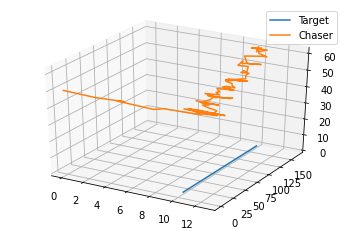


step:  76 chaser state:  [[ 10.48141816 166.01330043  61.66825793]
 [  0.7230769   -1.00608569  -0.26851772]] target state:  [  9.99997298 166.           0.           1.5707965 ]


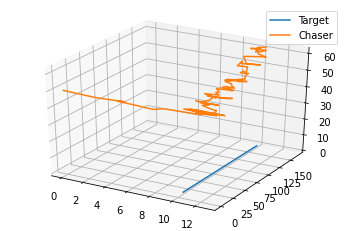


step:  77 chaser state:  [[  9.63421704 167.66247639  63.19360429]
 [  0.7531799   -0.93759513  -0.31470498]] target state:  [  9.99997263 168.           0.           1.5707965 ]


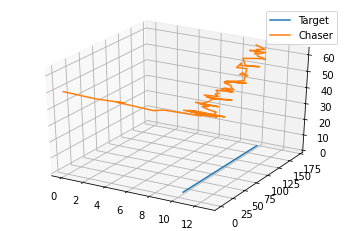


step:  78 chaser state:  [[  9.26013235 170.09468363  62.03059764]
 [  0.77940658  -0.97056743  -0.24758105]] target state:  [  9.99997229 170.           0.           1.5707965 ]


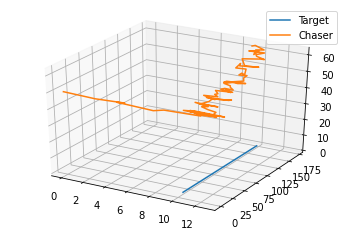


step:  79 chaser state:  [[  8.64666755 171.33662381  62.00116869]
 [  0.68857891  -1.02605293  -0.17436476]] target state:  [  9.99997194 172.           0.           1.5707965 ]


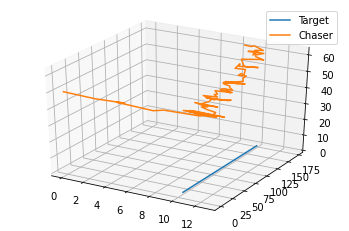


step:  80 chaser state:  [[  8.99905949 174.07121963  62.98371255]
 [  0.66041097  -1.10589527  -0.17687548]] target state:  [  9.99997159 174.           0.           1.5707965 ]


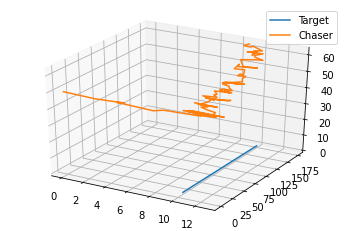


step:  81 chaser state:  [[  9.62329104 176.40433297  64.55473015]
 [  0.70351827  -0.98149167  -0.2316897 ]] target state:  [  9.99997125 176.           0.           1.5707965 ]


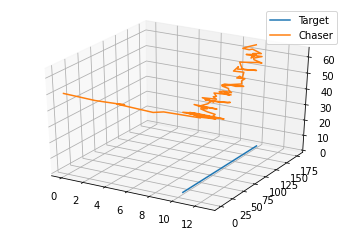


step:  82 chaser state:  [[  9.83832386 178.07721666  65.11266517]
 [  0.66567826  -1.02141983  -0.33160819]] target state:  [  9.9999709 178.          0.          1.5707965]


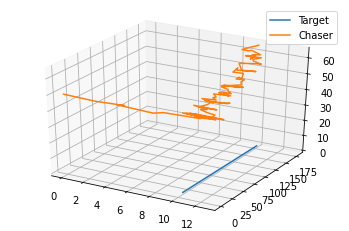


step:  83 chaser state:  [[ 10.73338907 179.38152769  65.38238524]
 [  0.66208879  -0.9853702   -0.21756003]] target state:  [  9.99997056 180.           0.           1.5707965 ]


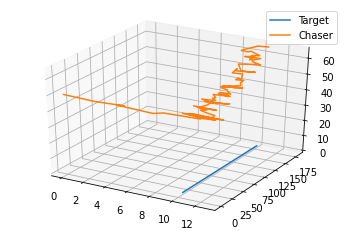


step:  84 chaser state:  [[ 10.11930673 182.39425242  64.77118369]
 [  0.66179367  -1.00600804  -0.18465748]] target state:  [  9.99997021 182.           0.           1.5707965 ]


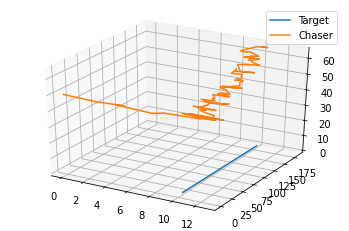


step:  85 chaser state:  [[ 10.4383195  184.20129406  62.97289265]
 [  0.60796729  -1.04703131  -0.2062275 ]] target state:  [  9.99996986 184.           0.           1.5707965 ]


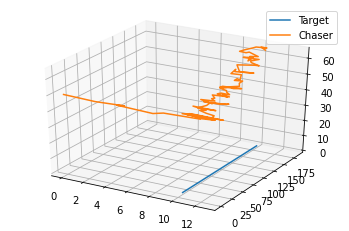


step:  86 chaser state:  [[ 9.75618336e+00  1.85744137e+02  6.15532582e+01]
 [ 7.15303264e-01 -1.02033554e+00 -8.29911488e-02]] target state:  [  9.99996952 186.           0.           1.5707965 ]


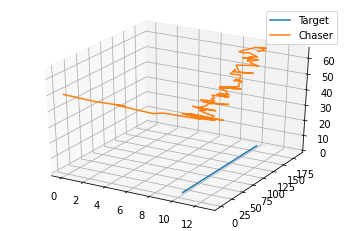


step:  87 chaser state:  [[ 9.13595382e+00  1.88851412e+02  6.17271980e+01]
 [ 7.01825810e-01 -9.87681822e-01 -1.00322753e-02]] target state:  [  9.99996917 188.           0.           1.5707965 ]


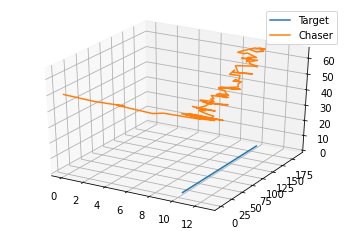


step:  88 chaser state:  [[ 9.79754494e+00  1.90469147e+02  6.21594050e+01]
 [ 6.55030824e-01 -1.10798219e+00 -9.75174944e-02]] target state:  [  9.99996882 190.           0.           1.5707965 ]


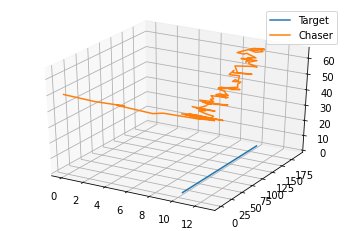


step:  89 chaser state:  [[ 1.01039766e+01  1.92561200e+02  6.39304668e+01]
 [ 7.49005671e-01 -1.09833720e+00 -5.10694366e-03]] target state:  [  9.99996848 192.           0.           1.5707965 ]


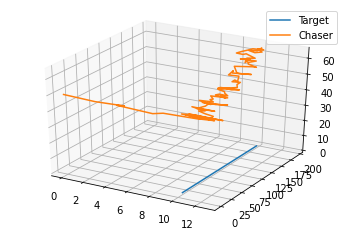


step:  90 chaser state:  [[ 1.05094989e+01  1.93288773e+02  6.62668241e+01]
 [ 7.31301979e-01 -1.20769848e+00  2.53498096e-02]] target state:  [  9.99996813 194.           0.           1.5707965 ]


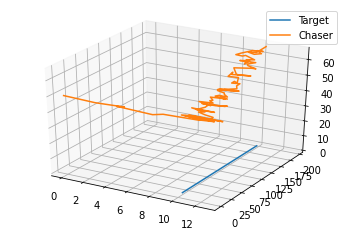


step:  91 chaser state:  [[ 9.82134411e+00  1.95940725e+02  6.44928912e+01]
 [ 7.10759026e-01 -1.21661095e+00 -6.73038344e-02]] target state:  [  9.99996778 196.           0.           1.5707965 ]


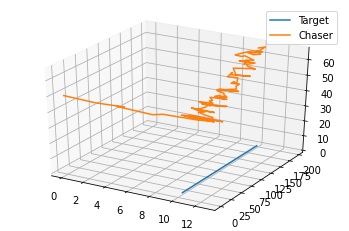


step:  92 chaser state:  [[ 1.04760527e+01  1.97660820e+02  6.24169591e+01]
 [ 5.87617591e-01 -1.09462231e+00 -7.24804837e-02]] target state:  [  9.99996744 198.           0.           1.5707965 ]


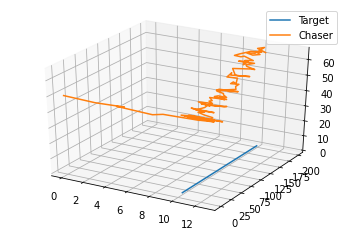


step:  93 chaser state:  [[ 1.06287709e+01  1.99806974e+02  6.49576984e+01]
 [ 5.81842571e-01 -1.16470461e+00 -2.14746717e-04]] target state:  [  9.99996709 200.           0.           1.5707965 ]


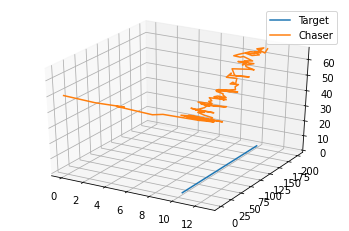


step:  94 chaser state:  [[ 1.01140525e+01  2.01879320e+02  6.57786594e+01]
 [ 6.48883417e-01 -1.21781110e+00 -2.21092103e-02]] target state:  [  9.99996674 202.           0.           1.5707965 ]


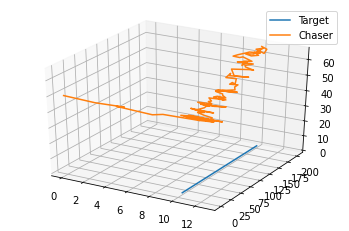


step:  95 chaser state:  [[ 1.00702285e+01  2.03494654e+02  6.81737840e+01]
 [ 6.12061157e-01 -1.32736857e+00  7.98472809e-03]] target state:  [  9.9999664 204.          0.          1.5707965]


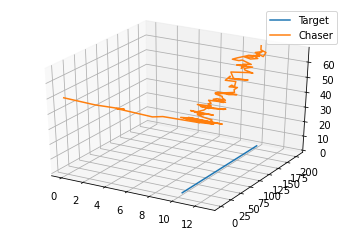


step:  96 chaser state:  [[ 9.98620874e+00  2.05239156e+02  7.11233443e+01]
 [ 7.00757942e-01 -1.40777262e+00  5.88866553e-02]] target state:  [  9.99996605 206.           0.           1.5707965 ]


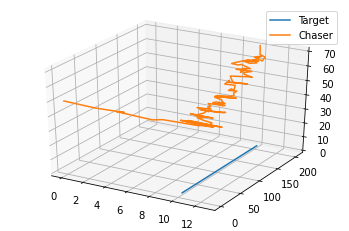


step:  97 chaser state:  [[ 8.79057278e+00  2.08049725e+02  6.90779879e+01]
 [ 5.84069414e-01 -1.32898155e+00  6.17050342e-03]] target state:  [  9.99996571 208.           0.           1.5707965 ]


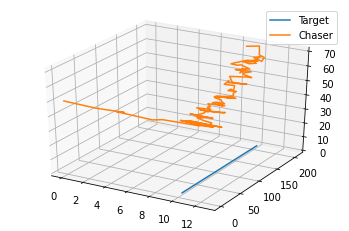


step:  98 chaser state:  [[ 9.07028153e+00  2.10296621e+02  6.63513767e+01]
 [ 6.19116120e-01 -1.20400463e+00  4.98101713e-02]] target state:  [  9.99996536 210.           0.           1.5707965 ]


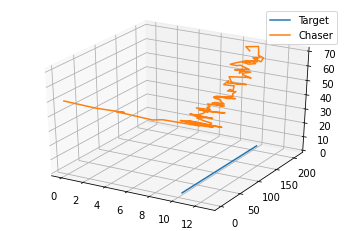


step:  99 chaser state:  [[ 1.07119169e+01  2.11435709e+02  6.64705683e+01]
 [ 6.70455486e-01 -1.28337724e+00  5.02976061e-02]] target state:  [  9.99996501 212.           0.           1.5707965 ]


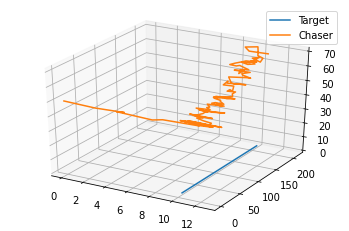


step:  100 chaser state:  [[ 9.62489271e+00  2.12722231e+02  6.94757319e+01]
 [ 6.75147803e-01 -1.27649574e+00 -3.59917279e-02]] target state:  [  9.99996467 214.           0.           1.5707965 ]


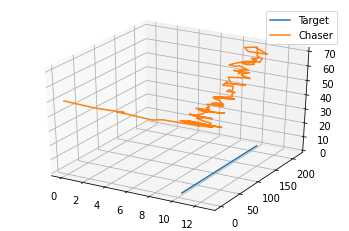

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline


initial_state = np.array([[0,0,50],[0,0,0]])
target_initial_state = np.array([10,10,0,pi/2])

curr_state,target_curr_state = optimizer(initial_state,target_initial_state)

num_steps = 100
j=0
chaser_states = [initial_state]
target_states = [target_initial_state]
while j <= num_steps:
  
  curr_state,target_curr_state = optimizer(curr_state,target_curr_state)
  print("\nstep: ",j,"chaser state: ", curr_state, "target state: ",target_curr_state)
  chaser_states.append(curr_state.tolist())
  target_states.append(target_curr_state.tolist())

  #plotting
  chaser_states_l = np.array(chaser_states)
  target_states_l = np.array(target_states)
  fig = plt.figure()
  ax = fig.gca(projection="3d")
  ax.plot(target_states_l.T[0], target_states_l.T[1], target_states_l.T[2],label = "Target");
  ax.plot(chaser_states_l[:,0].T[0], chaser_states_l[:,0].T[1], chaser_states_l[:,0].T[2],label = "Chaser");
  ax.legend()
  plt.show()

  j+=1

chaser_states = np.array(chaser_states)
target_states = np.array(target_states)
# print(states)







/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


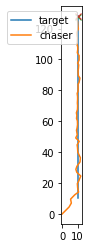

In [ ]:
plt.plot(target_states_l.T[0],target_states_l.T[1],label = "target")
plt.plot(chaser_states_l[:,0].T[0],chaser_states_l[:,0].T[1],label = "chaser")
plt.plot(chaser_states_l[:,0].T[0][-1],chaser_states_l[:,0].T[1][-1],"x")
plt.plot(target_states_l.T[0][-1],target_states_l.T[1][-1],"x")
plt.axes().set_aspect("equal")
plt.legend()
plt.show()
# plt.savefig('/content/drive/My Drive/MTE_Project/chaser4.jpg')

In [ ]:
import scipy
from scipy.io import savemat
mdic = {"chaser": chaser_states_l}
mdic2 = {"target": target_states_l}
scipy.io.savemat('chaser_lin.mat', mdic)
scipy.io.savemat('target_lin.mat', mdic2)

In [ ]:
vel = np.array([10,12,10])
omega = np.array([pi/10,pi/10,pi/10])

pos = np.array([0,0,0])
angle = np.array([0,0,0])
phi,theta,psi = angle

rotmat_omega = np.array([[1,sin(phi)*tan(theta),cos(phi)*tan(theta)],\
                          [0,cos(phi),-sin(phi)],\
                          [0,sin(phi)/cos(theta),cos(phi)/cos(theta)]])

rotmat_velocity = np.array([[cos(theta)*cos(psi),sin(phi)*sin(theta)*cos(psi)-cos(phi)*sin(psi),cos(phi)*sin(theta)*cos(psi)+sin(phi)*sin(psi)],\
                            [cos(theta)*sin(psi),sin(phi)*sin(theta)*sin(psi)+cos(phi)*cos(psi),cos(phi)*sin(theta)*sin(psi)-sin(phi)*cos(psi)],\
                            [sin(theta),-sin(phi)*cos(theta),-cos(phi)*cos(theta)]])

pos = pos + np.matmul(rotmat_velocity,vel)*delta_t
# print("pos",pos) #testcode
# print("mat",np.matmul(rotmat_velocity,vel)*delta_t) #testcode
# print("rotmat",rotmat_velocity)
angle = angle + np.matmul(rotmat_omega,omega)*delta_t
print("angle",angle)
print("rotmat_om",rotmat_omega)

curr_pos = np.array([pos,angle])
print("curr_pos",curr_pos)

# #getting target position
# self.new_target_state = self.cal_target_state() #updating new target state
# self._state = curr_pos #updating new chaser state
# cost = np.sqrt(np.sum((self.new_target_state[:-1]-curr_pos[0])**2)) #calculating cost

angle [0.06283186 0.06283186 0.06283186]
rotmat_om [[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
curr_pos [[ 2.          2.4        -2.        ]
 [ 0.06283186  0.06283186  0.06283186]]
